In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd
from pathlib import Path

from utils.data import load_xval_test_set
from utils.plotting import load_default_mpl_config, savefig
from utils.metrics import compute_metrics

load_default_mpl_config()

PLOT_PATH = Path('/mydata/machflow/basil/mach-flow/analysis/timeseries_vis/')
runoff_vars = ['Qmm', 'Qmm_mod', 'Qmm_prevah']

def merged_df(mod, prevah):
    x_mod = mod.to_dataframe().reset_index()
    x_mod['source'] = 'mod'
    x_pre = prevah.to_dataframe().reset_index()
    x_pre['source'] = 'prevah'
    x_both = pd.concat((x_mod, x_pre)).reset_index()

    return x_both

In [2]:
# xval_ds = load_xval('/mydata/machflow/basil/runs/basin_level/').compute()
# xval_ds = xval_ds.where((xval_ds.folds >= 0), drop=True).compute()

xval_ds = load_xval_test_set(
        xval_dir='/mydata/machflow/basil/runs/basin_level/staticall_allbasins_sqrttrans/LSTM/xval/'
    ).isel(tau=0).drop_vars('tau')

In [3]:
xval_ds = xval_ds.sortby(xval_ds.Qmm.notnull().sum('time'))

In [4]:
import pandas as pd

fig = plt.figure(frameon=False)
fig.set_size_inches(8, 3)
ax = plt.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()
fig.add_axes(ax)

cmap = mcolors.ListedColormap(['1.0', '0.8'])

xval_ds.Qmm.notnull().plot(ax=ax, cmap=cmap, add_colorbar=False)


eval_times = [
    ['1993-01-01', '1994-12-31'],
    ['2000-01-01', '2001-12-31'],
    ['2014-01-01', '2015-12-31'],
    ['2021-01-01', '2023-12-31'],
]

test_times = [
    ['1995-01-01', '1999-12-31'],
    ['2016-01-01', '2020-12-31'],
]

for s, e in eval_times:
    ax.axvspan(s, e, alpha=0.5, facecolor='0.4', zorder=1)
    ax.axvspan(s, e, alpha=0.5, facecolor='none', edgecolor='0.4', hatch='//', zorder=2)

for s, e in test_times:
    ax.axvspan(s, e, alpha=0.5, facecolor='0.2', zorder=1)
    ax.axvspan(s, e, alpha=0.5, facecolor='none', edgecolor='0.2', hatch='\\\\', zorder=2)

# ax.spines[['left', 'top', 'right', 'bottom']].set_visible(False)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_yticks([])
ax.set_xticks([])
ax.set_xticklabels([])


#ax.axis('off')

fig.savefig('./catchment_timesplit.png', dpi=600, transparent=False, bbox_inches='tight', pad_inches=0)

In [ ]:
catchments = {
    'CHFO-0181': 'Murg–Frauenfeld\nRain dominated',
    'CHFO-0190': 'Aabach-Hitzkirch\nLake dominated',
    'CHFO-0112': 'Plessur-Chur\nSnow dominated',
    'CHFO-0126': 'Simme-Oberried/Lenk\nGlacier dominated',
}

/mydata/machflow/basil/mach-flow/utils/plotting.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


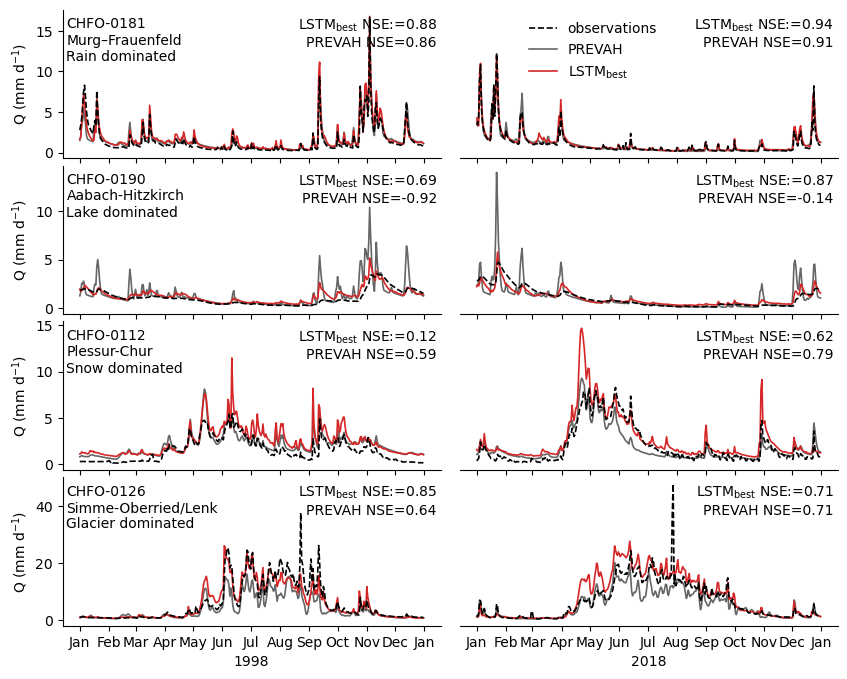

In [ ]:
fig, axes = plt.subplots(
    nrows=len(catchments),
    ncols=2,
    figsize=(10, 2 * len(catchments)),
    sharey='row',
    sharex='col',
    gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

time_subsets = [
    '1998',
    '2018'
]

for s, (station_id, station_desc) in enumerate(catchments.items()):
    for i, time_subset in enumerate(time_subsets):

        ax = axes[s, i]

        ds_sel = xval_ds.sel(time=time_subset, station=station_id).compute()

        nse_mod = compute_metrics(obs=ds_sel.Qmm, mod=ds_sel.Qmm_mod, metrics=['nse']).nse.item()
        nse_prevah = compute_metrics(obs=ds_sel.Qmm, mod=ds_sel.Qmm_prevah, metrics=['nse']).nse.item()

        ax.plot(
            ds_sel.time,
            ds_sel.Qmm,
            color='k',
            lw=1.2,
            ls='--',
            zorder=10,
            label='observations'
        )
        ax.plot(
            ds_sel.time,
            ds_sel.Qmm_prevah,
            color='0.4',
            lw=1.2,
            # ls='--',
            label='PREVAH'
        )
        ax.plot(
            ds_sel.time,
            ds_sel.Qmm_mod,
            color='tab:red',
            lw=1.2,
            label=r'LSTM$_\mathrm{best}$'
        )

        if i == 0:
            ax.spines[['right', 'top']].set_visible(False)
            ax.set_ylabel('Q (mm d$^{-1}$)')
            ax.text(0.01, 0.95, f'{["a)", "b)", "c)", "d)"][s]}{station_id}\n{station_desc}', ha='left', va='top', transform=ax.transAxes)
         
        else:
            ax.spines[['right', 'top', 'left']].set_visible(False)
            ax.tick_params('y', length=0, width=0, which='major')


        ax.text(
            0.99, 0.95,
            f'LSTM$_\mathrm{{best}}$ NSE:={nse_mod:0.2f}\nPREVAH NSE={nse_prevah:0.2f}',
            ha='right', va='top', transform=ax.transAxes)

        ax.xaxis.set_major_formatter(
            mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

        fmt_month = mdates.MonthLocator()
        ax.xaxis.set_major_locator(fmt_month)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

        if s == len(catchments) - 1:
            ax.set_xlabel(time_subset)
        else:
            ax.set_xlabel('')

axes[0, 1].legend(frameon=False, loc=2, bbox_to_anchor=(0.15, 1.0))

savefig(fig, path=PLOT_PATH / 'ts_plot.png')

In [2]:
import xarray as xr


def decode_time_string(x: list[str]) -> list[slice]:
    if not isinstance(x, list):
        raise TypeError(
            f'`x` must be `None` or a `list`, is `{type(x).__name__}`.'
        )

    if len(x) == 0:
        raise ValueError(
            '`x` must not be empty.'
        )

    time_slices = []
    for el in x:
        if not isinstance(el, str):
            raise ValueError(
                f'element \'{el}\' must be of type `str`, is `{type(el).__name__}`.'
            )

        if ',' not in el:
            raise ValueError(
                'each time item must be a comma separated pair of start time, end time, e.g., \'2001,2003-05-01\', '
                f'but no comma found in element \'{el}\'.'
            )

        if ' ' in el:
            raise ValueError(
                'each time item must be a comma separated pair of start time, end time, e.g., \'2001,2003-05-01\', '
                f'with no whitespaces, but whitespace found in element \'{el}\'.'
            )

        start_date, end_date = el.split(',')

        try:
            xr.cftime_range(start_date, end_date)

        except Exception as e:
            raise RuntimeError(
                f'Could not parse element \'{el}\' to time stamps. Infered time start was \'{start_date}\' and '
                f'time end was \'{end_date}\'.'
            )
        
        time_slices.append(slice(start_date, end_date))

    return time_slices


In [9]:
def mask_time_slices(mask: xr.DataArray, time_slices: list[slice]) -> xr.DataArray:
    time_mask = xr.full_like(mask, False)

    for time_slice in time_slices:
        time_mask.loc[{'time': time_slice}] = True

    print(type(time_mask), type(mask))

    mask = mask & time_mask

    return mask


In [18]:
tranges = decode_time_string(['2001-01-01,2002-02-02', '2004-04-04,2005-05-05'])

In [19]:
ds = xr.open_zarr('/mydata/machflow/basil/data/harmonized_basins.zarr/')

In [23]:
mask = xr.full_like(ds['Qmm'], True, dtype=bool)

In [24]:
mask

<xarray.DataArray 'Qmm' (station: 574, time: 23010)>
dask.array<full_like, shape=(574, 23010), dtype=bool, chunksize=(1, 23010), chunktype=numpy.ndarray>
Coordinates:
  * station  (station) <U9 'CHAG-0001' 'CHAG-0002' ... 'MACH-0064' 'MACH-0076'
  * time     (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2023-12-31

In [25]:
tmask = mask_time_slices(mask, tranges)

<class 'xarray.core.dataarray.DataArray'> <class 'xarray.core.dataarray.DataArray'>


In [41]:
import numpy as np
warmup_size = 365
tmask.time[max(np.argwhere(tmask.any('station').compute().values)[0] - warmup_size - 1, 0)].dt.strftime('').item()

'2000-01-01'

In [5]:
time = xr.cftime_range('2000', '2009')
da = xr.DataArray(True, dims=['time'], coords=[time])

In [6]:
for time_slice in time_sel:
    da.loc[{'time': time_slice}] = True

In [7]:
da_test = xr.DataArray(False, dims=['time'], coords=[time])

In [10]:
r = mask_time_slices(mask=da_test, time_slices=time_sel)

<class 'xarray.core.dataarray.DataArray'> <class 'xarray.core.dataarray.DataArray'>


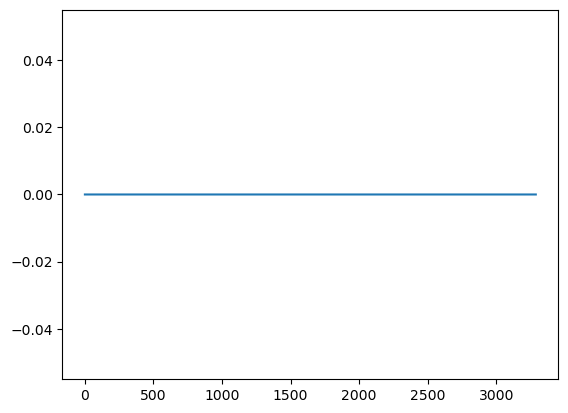

In [56]:
plt.plot(r.values)